## Basic 2D FEM Example - with a larger mesh

First import the required libraries for basic algebra and plotting

In [1]:
from numpy import *
set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

### Mesh
Generate a two-dimensional mesh of triangles. We define two arrays, one for "topology" which is a list of indices (three for each triangle), and one for "geometry" which is a list of points (two floating-point numbers per point).

In [2]:
# Make a rectangular mesh of triangles, nx by ny 
nx = 25
ny = 25

# Set w = 0.03 for a wiggly mesh!
w = 0.00

# Create an array of points
c = 0
geometry = zeros((nx*ny, 2), dtype='float')
for i in range(nx):
    for j in range(ny):
        geometry[c] = [float(i/(nx-1)), float(w*sin(i) + j/(ny-1))]
        c += 1

ntri = (nx - 1)*(ny - 1)*2
topology = zeros((ntri, 3), dtype='int')

c = 0
for i in range(nx - 1):
    for j in range(ny - 1):
        ij = j + i*ny
        topology[c] = [ij, ij+ny, ij+ny+1]
        topology[c + 1] = [ij+1, ij, ij+ny+1]
        c += 2
        
mesh = (geometry, topology)

Here is a simple plotting routine to display the mesh, and also the data values, if we have any (the details of the plotting routine are not important)

In [3]:
def plot(mesh, data=None):
    geom, topo = mesh
    x = geom[:,0]
    y = geom[:,1]

    plt.gca(aspect='equal')
    
    if data is not None:
        plt.tricontourf(x, y, topo, data, 40)
    else:
        plt.triplot(x, y, topo, color='k', alpha=0.5)
        
    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    dx = 0.1*(xmax - xmin)
    dy = 0.1*(ymax - ymin)
    plt.xlim(xmin-dx, xmax+dx)
    plt.ylim(ymin-dy, ymax+dy)
    return


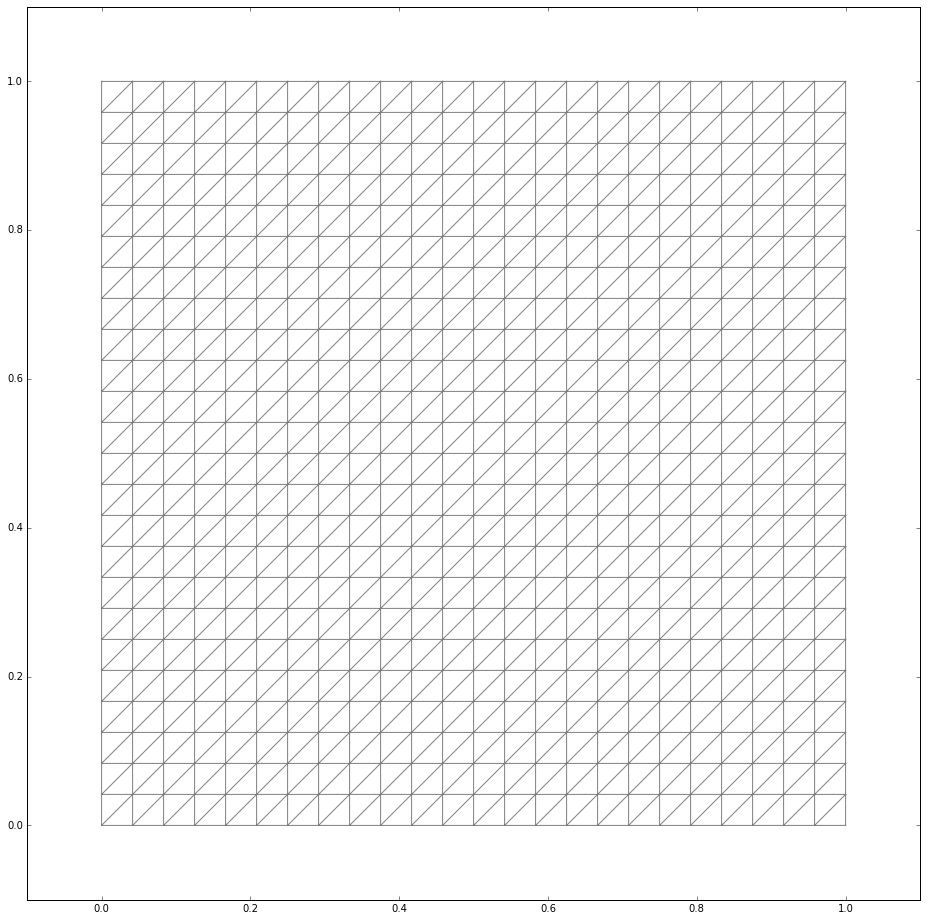

In [5]:
plt.figure(figsize=(16,16))
plot(mesh)

### Element matrix
The "element stiffness matrix", $K$ depends on the conductivity tensor $D$ and the triangle geometry.

$$ K_e = \int_{\Omega_e} B_e^T D B_e d\Omega $$


In [6]:
def Kmat(D, p, geometry):
    ''' Calculate K from the D matrix and the points '''
    # D contains the conductivity tensor
    # p contains the indices of the three points
    # making up the triangle
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))

    # 'B' Matrix - representing the 'gradient' operator
    B = array([[y1 - y2, y2 - y0, y0 - y1],
               [x2 - x1, x0 - x2, x1 - x0]])/(2*Ae)

    K = Ae*matmul(B.transpose(), matmul(D, B))
    return K

### Matrix assembly (LHS)
The process of combining the local element matrices into a larger global matrix is called "assembly". It is really just a case of relabelling the indices with their global values, and adding the local matrices together.

In [7]:
def assemble_matrix(mesh, Dmat):
    geom, topo = mesh
    np = len(geom)
    Kglobal = zeros((np, np))
    
    for tri in topo:
        K = Kmat(Dmat, tri, geom)
        for i, idx in enumerate(tri):
            for j, jdx in enumerate(tri):
                Kglobal[idx, jdx] += K[i, j]
    return Kglobal

In [8]:
Dmat = array([[15.0, 0.0],
              [0.0, 5.0]])

In [9]:
Kglobal = assemble_matrix(mesh, Dmat)

The fully assembled left-hand side (LHS) looks like this (image shows non-zero entries in black):

[[ 10.   -2.5   0.  ...,   0.    0.    0. ]
 [ -2.5  20.   -2.5 ...,   0.    0.    0. ]
 [  0.   -2.5  20.  ...,   0.    0.    0. ]
 ..., 
 [  0.    0.    0.  ...,  20.   -2.5   0. ]
 [  0.    0.    0.  ...,  -2.5  20.   -2.5]
 [  0.    0.    0.  ...,   0.   -2.5  10. ]]


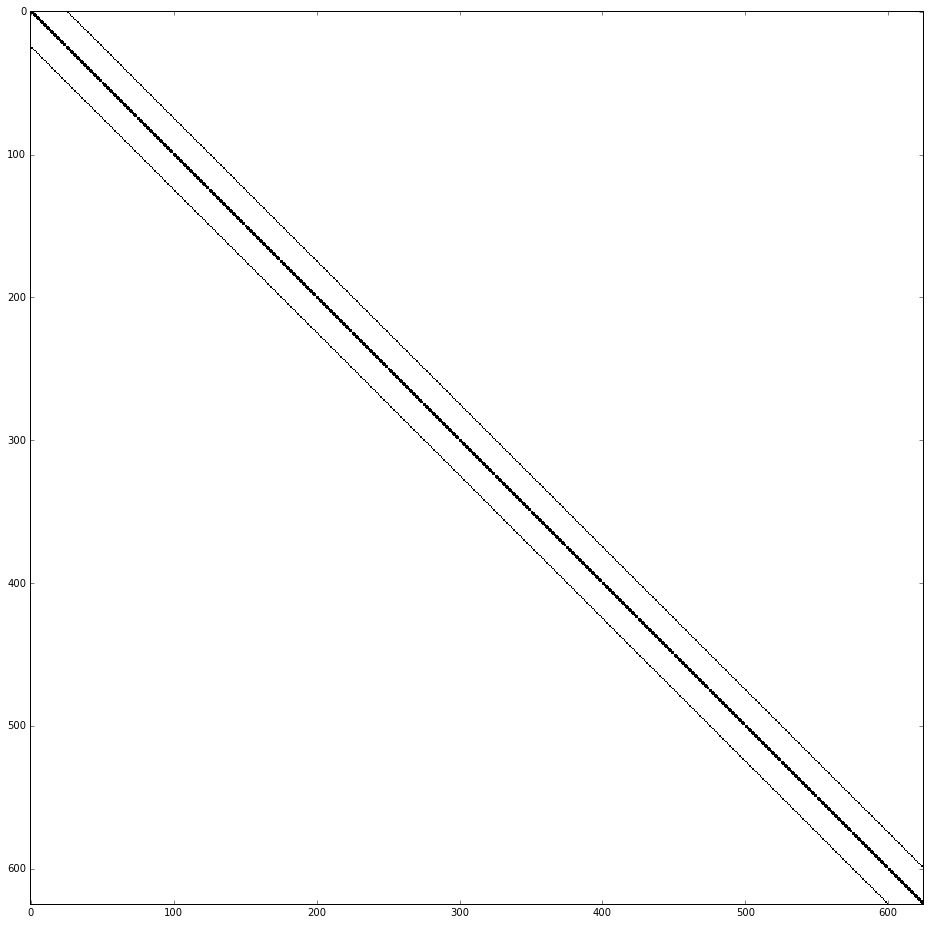

In [10]:
print(Kglobal)
# Show the non-zero structure of the matrix
plt.figure(figsize=(16,16))
nz = plt.imshow((Kglobal != 0), interpolation='nearest', cmap='Greys')

### RHS assembly

Now we need to perform RHS assembly on the vector $f$, combining the local vector entries from each element. Each element has a constant source term $s$.


In [11]:
def fvec(s, p, geom):
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    return s*Ae/3.0*ones(3)

def assemble_vector(mesh, s):
    geom, topo = mesh
    fg = zeros(len(geom))
    for tri in topo:
        f = fvec(s, tri, geom)
        for i, idx in enumerate(tri):
            fg[idx] += f[i]
    return fg

fglobal = assemble_vector(mesh, 3.0)

In [15]:
def set_bc(K, f, row, val):
    # Set BC
    K[row] = 0.0
    K[row, row] = 1.0
    f[row] = val
    
# Set u=2 BC on left edge
for j in range(ny):
    set_bc(Kglobal, fglobal, j, 2.0)
    
# Set zero BC on bottom edge
for i in range(nx):
    set_bc(Kglobal, fglobal, i*ny, 0.0)
    



Finally, we can refer the $K.u = f$ problem to a linear algebra solver which will use an LU method to get the answer

In [16]:
u = linalg.solve(Kglobal, fglobal)
print(u.max(), u.min())


2.0 -2.86499588991e-15


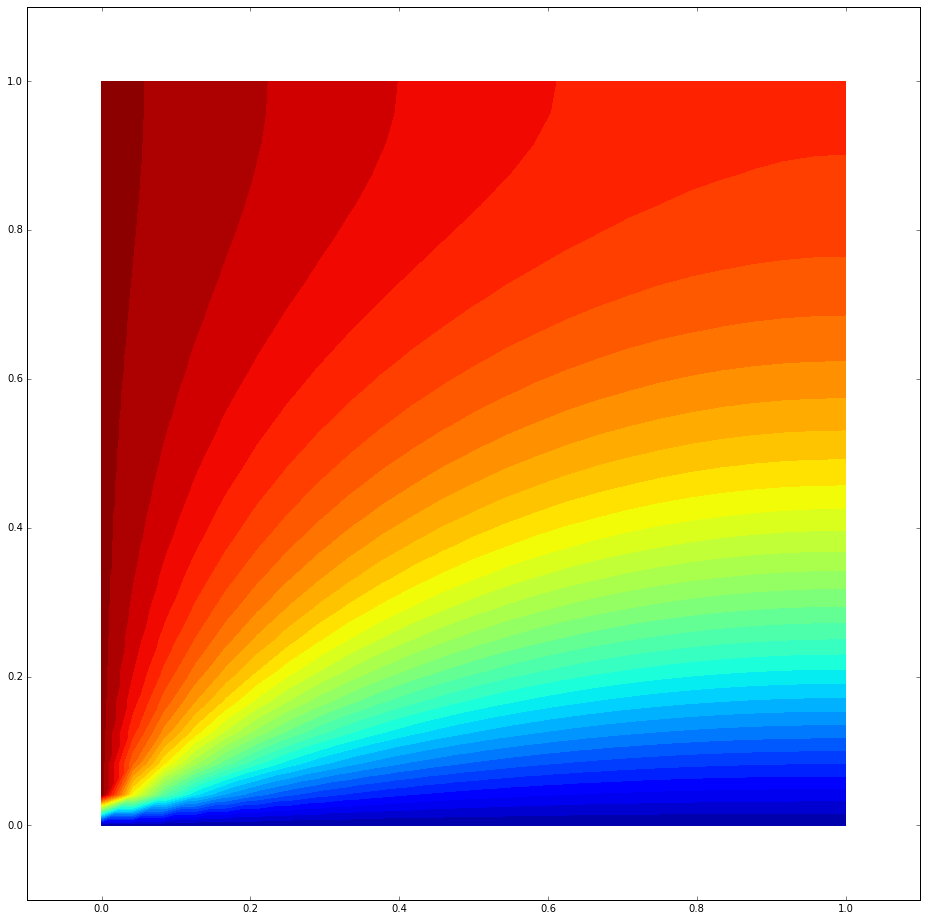

In [17]:
plt.figure(figsize=(16,16))
plot(mesh, u)

Experiment with some different values. Try changing the conductivity tensor $D$. Try changing the boundary conditions, or adding some flux terms. Try making $D$, or the source term ($s$) a function of space, and re-run the notebook.